In [1]:
import jax
import jax.numpy as jnp 
import jax.random as jr
import optax

import sbgm

Here we're going to train a score-based diffusion model to generate log-normal random fields $\boldsymbol{x}$ conditioned on Gaussian random fields $\boldsymbol{q}$ and power spectrum parameters $\alpha$.

The power spectrum that generates the Gaussian field is given by $P(k)=A\times k^B$, where $\alpha=(A,B)$.

This is a rough analogy to late time matter density fields in the Universe.

In [18]:
from watermark import watermark

print(watermark(packages="numpy,optax,jax,diffrax,equinox,einops,beartype,tqdm,matplotlib,powerbox,cloudpickle,torch,torchvision,einx"))

numpy      : 1.26.4
optax      : 0.2.3
jax        : 0.4.33
diffrax    : 0.6.0
equinox    : 0.11.7
einops     : 0.8.0
beartype   : 0.19.0
tqdm       : 4.66.4
matplotlib : 3.9.1
powerbox   : 0.8.1
cloudpickle: 3.0.0
torch      : 2.4.0
torchvision: 0.19.0
einx       : 0.3.0



In [2]:
# Load (data) and save (model, samples & optimiser state) directories 
datasets_path = "../datasets/"
root_dir = "./"

n_devices = len(jax.devices())

In [3]:
key = jr.key(0)

data_key, model_key, train_key = jr.split(key, 3)

# Data
dataset_name          = "grfs" 
n_pix                 = 32
img_shape             = (1, n_pix, n_pix)
context_shape         = (1, n_pix, n_pix)
parameter_dim         = 2 # Power spectrum amplitude and index

# Model
is_biggan             = False
dim_mults             = [1, 1, 1]
hidden_size           = 128
heads                 = 4
dim_head              = 64
dropout_rate          = 0.3
num_res_blocks        = 2
attn_resolutions      = [8, 16, 32]
final_activation      = None

# SDE
t1                    = 8.
t0                    = 0.
dt                    = 0.1
beta_integral         = lambda t: t 
weight_fn             = lambda t: 1. - jnp.exp(-beta_integral(t)) 

# Sampling
use_ema               = False
sample_size           = 5 # Squared for a grid
exact_logp            = False
ode_sample            = True # Sample the ODE during training
eu_sample             = True # Euler-Maruyama sample the SDE during training

# Optimisation hyperparameters
start_step            = 0
n_steps               = 1_000_000
batch_size            = 10 * n_devices
sample_and_save_every = 1_000
lr                    = 1e-4
opt                   = optax.adamw
opt_kwargs            = {} 

We will generate a Gaussian random field and a log-nornal field given a set of power spectrum parameters we sample from a uniform prior.

In [4]:
from data import grfs

# Dataset object of training data and loaders
dataset = grfs(data_key, n_pix=n_pix, n_fields=1000)

Building fields...
 n=999
Fields data: (1000, 1, 32, 32) (1000, 1, 32, 32)


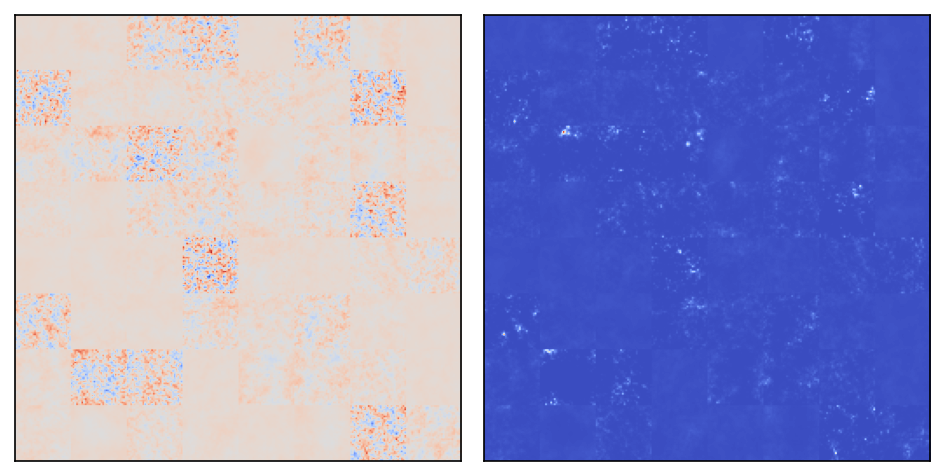

In [5]:
from einops import rearrange 
import matplotlib.pyplot as plt

n_plot = 8 # Grid side length in images
cmap = "coolwarm"

# Grab a batch to plot from the dataloader
X, Q, A = next(dataset.train_dataloader.loop(n_plot ** 2))

fig, axs = plt.subplots(1, 2, dpi=150)
ax = axs[0]
ax.imshow(
    rearrange(Q, "(h w) c x y -> (h x) (w y) c", h=n_plot, w=n_plot, x=n_pix, y=n_pix), 
    cmap=cmap
)
ax = axs[1]
ax.imshow(
    rearrange(X, "(h w) c x y -> (h x) (w y) c", h=n_plot, w=n_plot, x=n_pix, y=n_pix), 
    cmap=cmap
)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

This example is run with multiple GPU accelerators (you may have to reduce the batch size or model parameters without them).

In [6]:
# Multiple GPU training if you are so inclined
sharding, replicated_sharding = sbgm.shard.get_shardings()

Running on 4 local devices: 
	[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


We'll use a UNet with an multihead-attention mechanism and time conditioning. Pretty standard for generative models.

In [7]:
from sbgm.models import UNet

n_channels, *_ = img_shape

# Diffusion model 
model = UNet(
    dim=hidden_size,
    channels=n_channels,
    dim_mults=dim_mults,
    attn_heads=heads,
    attn_dim_head=dim_head,
    dropout=dropout_rate,
    learned_sinusoidal_cond=True,
    random_fourier_features=True,
    a_dim=parameter_dim,          # Number of parameters in power spectrum model
    q_channels=context_shape[0],  # Number of channels in conditioning map
    key=model_key
)

Here is our stochastic differential equation (SDE) which describes how we perturb our fields with noise.

You can see an example of diffusing a log-normal field here. The colourmap is restricted to the data pixel values (hence the blank pixels).

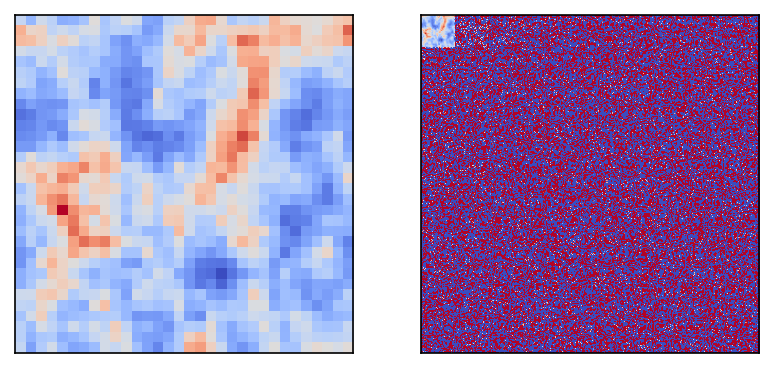

In [8]:
from sbgm.sde import VPSDE

# Stochastic differential equation (SDE)
sde = VPSDE(
    beta_integral_fn=beta_integral,
    dt=dt,
    t0=t0, 
    t1=t1,
    weight_fn=weight_fn
)

def diffuse(x, t, eps):
    mu, std = sde.marginal_prob(x, t)
    return mu + std * eps
    
n_side = 10
n_t = 100

imgs = [X[0]]
for i, t in enumerate(jnp.linspace(t0, t1, n_t)):

    eps = jr.normal(jr.fold_in(key, i), img_shape) * 0.05 # Illustration purposes!

    Xt = diffuse(imgs[i], t, eps)

    imgs.append(Xt)

fig, axs = plt.subplots(1, 2, dpi=150)
ax = axs[0]
ax.imshow(imgs[0].transpose(1, 2, 0), cmap=cmap)
ax = axs[1]
ax.imshow(
    rearrange(imgs[1:], "(h w) c x y -> (h x) (w y) c", h=10, w=10, x=n_pix, y=n_pix), 
    cmap=cmap,
    vmin=imgs[0].min(),
    vmax=imgs[0].max()
)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [9]:
# Fit model to dataset
model = sbgm.train.train(
    train_key,
    model,
    sde,
    dataset,
    opt=opt(lr, **opt_kwargs),
    n_steps=n_steps,
    batch_size=batch_size,
    sample_size=sample_size,
    eu_sample=eu_sample,
    ode_sample=ode_sample,
    reload_opt_state=False,
    plot_train_data=True,
    sharding=sharding,
    replicated_sharding=replicated_sharding,
    save_dir=root_dir,
    cmap=cmap
)

Training SGM with a VPSDE on grfs dataset.


  0%|          | 0/1000000 [00:00<?, ?it/s]

E0109 10:54:18.097881    3747 cuda_blas.cc:196] failed to create cublas handle: the resource allocation failed
E0109 10:54:18.097939    3747 cuda_blas.cc:199] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
E0109 10:54:18.385846    3747 cuda_blas.cc:196] failed to create cublas handle: the resource allocation failed
E0109 10:54:18.385871    3747 cuda_blas.cc:199] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
E0109 10:54:18.459530    3747 cuda_blas.cc:196] failed to create cublas handle: the resource allocation failed
E0109 10:54:18.459546    3747 c

XlaRuntimeError: UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bw-filter = (f32[128,2,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,2,32,32]{3,2,1,0} %concatenate.336, f32[10,128,32,32]{3,2,1,0} %add.16231), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_name="jit(make_step)/jit(main)/transpose(jvp(jit(batch_loss_fn)))/vmap(eqx.nn.Conv)/conv_general_dilated" source_file="/project/ls-gruen/users/jed.homer/1pt_pdf/little_studies/sgm_lib/.venv/lib/python3.12/site-packages/equinox/nn/_conv.py" source_line=239}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: INTERNAL: All algorithms tried for (f32[128,2,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,2,32,32]{3,2,1,0}, f32[10,128,32,32]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} failed. Falling back to default algorithm.  Per-algorithm errors:
  Profiling failure on cuDNN engine eng20{k2=6,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng20{k2=8,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng20{k2=0,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng18{k11=2}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng1{k2=6,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng20{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng21{k2=1,k4=2,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng21{k2=0,k4=2,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng1{k2=0,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng1{k2=2,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng20{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng21{k2=2,k4=3,k5=0,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'
  Profiling failure on cuDNN engine eng21{k2=1,k4=3,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(6122): 'status'

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.

Now we can calculate the likelihood of a log-normal map given a Gaussian field and $P(k)$ parameterisation. 

In [ ]:
from sbgm._ode import get_log_likelihood_fn

log_likelihood_fn = get_log_likelihood_fn(
    model, sde, dataset.data_shape, exact_logp=True
)
L_X = log_likelihood_fn(X[0], Q[0], A[0], key)

L_X